# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

# Imports

In [3]:
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import sys
import scipy.constants as sc
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.linalg import dft

np.set_printoptions(threshold=sys.maxsize)
# plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-darkgrid')

In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in Matplo

# Signal and system parameters

In [4]:
class Params():
    def __init__(self, L=1000, B=1e9):
        # variables
        self.L = L  # distance (m)
        self.B = B  # bandwidth (GHz)

        # physical constants
        self.c = 3e8
        self.a_dB = 0.2  # power loss in dB
        self.D = 17e-6  # dispersion ps/(nm-km)
        self.gamma = 1.27e-3  # nonlinearity coefficient (W^-1.m^-1)
        self.nsp = 1  # a constant factor
        self.h = sc.Planck  # Planck constant (J.s)
        self.lambda0 = 1.55e-6  # center wavelength (m)
        self.f0 = self.c/self.lambda0  # center frequency (Hz)

        self.alpha = self.a_dB*1e-4*np.log2(10)  # loss coefficient (m^-1)
        self.beta2 = -(self.lambda0**2/(2*np.pi*self.c))*self.D  # dispersion coefficient (s².m^-1)

        # scale factors
        self.L0 = self.L  # (km)
        self.T0 = np.sqrt(np.abs(self.beta2)*self.L/2)  # (s)
        self.P0 = 2/(self.gamma*self.L)  # (W)

        # noise PSD
        self.sigma02 = self.nsp*self.h*self.alpha*self.f0  # physical (W.Hz^-1.m^-1)
        self.sigma2 = self.sigma02*self.L/(self.P0*self.T0) # normalized
    
    def setL(self, L):
        self.L = L
        self.__init__(L=L)
    
    def setB(self, B):
        self.B = B
        self.__init__(B=B)


#Transmitter

## Gray Coding for QAM Constellation

In [5]:
def grayCoding(n, M):
    k = int(np.log2(M))

    reAxis = np.hstack((np.arange(-(np.sqrt(M)//2), 0, step=1),
                        np.arange(1, np.sqrt(M)/2+1, step=1)))
    imAxis = np.copy(reAxis)

    bin = np.unpackbits(np.array([n], dtype=np.uint8))[8-k:]

    rePart = bin[:k//2]
    imPart = bin[k//2:]

    aReBin = np.hstack((np.zeros(8-k//2, dtype=np.uint8), rePart))
    aImBin = np.hstack((np.zeros(8-k//2, dtype=np.uint8), imPart))

    aReDec = np.packbits(aReBin)
    aImDec = np.packbits(aImBin)

    reIndex = np.bitwise_xor(aReDec, aReDec//2)[0]
    imIndex = np.bitwise_xor(aImDec, aImDec//2)[0]

    return  bin, complex(reAxis[reIndex], imAxis[imIndex])

## Plot the M-QAM Constellation Diagram

In [6]:
def plotMQAM(M):
    coords, binaries, a = getConstellation(M)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    fig.suptitle(f'{M}-QAM Constellation')
    ax.set_xlabel('Real Part')
    ax.set_ylabel('Imaginary Part')

    ax.scatter(coords.real, coords.imag)

    for i, text in enumerate(binaries):
        ax.annotate(text, (coords.real[i], coords.imag[i]),
                    xytext=(coords.real[i]-0.2, coords.imag[i]-0.2))

    ax.axis([-(np.sqrt(M)//2)-1, np.sqrt(M)/2+1, -(np.sqrt(M)//2)-1, np.sqrt(M)/2+1])
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    
    plt.show()
    return


def getConstellation(M):
    k = int(np.log2(M))
    N = np.arange(0, M, dtype=np.int32)
    coords = []
    binaryStr = []
    binaryArr = np.zeros((M, k), dtype=np.uint8)
    for n in N:
        bin, code = grayCoding(n, M)
        coords.append(code)
        binaryArr[n] = bin
        binaryStr.append(np.binary_repr(n, width=k))

    coords = np.array(coords)

    return coords, binaryStr, binaryArr


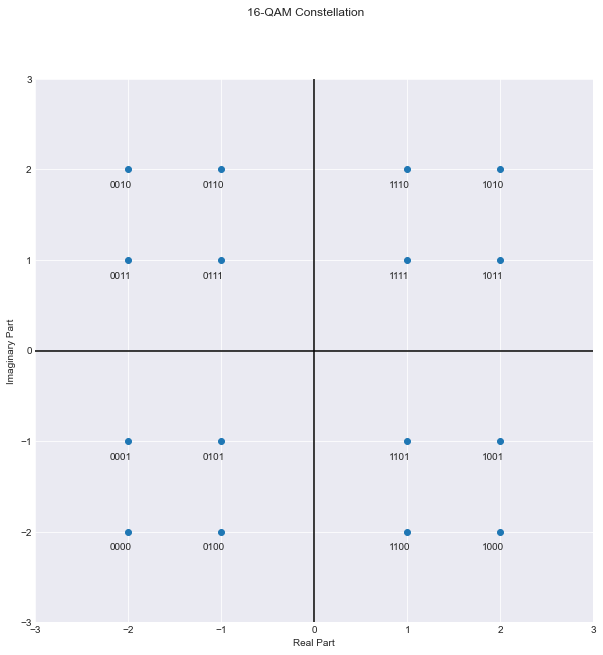

In [7]:
# Test the function
plotMQAM(16)

## Bernoulli Distribution

In [8]:
def source(N, p):
    b = np.zeros((N, 1), dtype=np.int32)
    for i in range(N):
        x = np.random.choice([0, 1], p=[p, 1-p])
        b[i] = x
    return b

In [9]:
# Test the function
N = 1024
p = 0.5

b = source(N, p)

print(np.mean(b))

0.484375


## Bits to Symbols Conversion for M-QAM Constellation

In [10]:
def bitToSymb(b, M):
    k = int(np.log2(M))
    if b.size % k != 0:
        b = np.vstack((b, np.zeros((6-b.size % k, 1), dtype=np.uint8)))
    bits = b.reshape((-1, k))
    symboles = []
    for bi in bits:
        biDec = np.packbits(np.hstack((np.zeros(8-k, dtype=np.uint8), bi)))[0]
        bin, code = grayCoding(biDec, M)
        symboles.append(code)

    return np.array(symboles)

In [11]:
# Test the function
N = 1024
p = 0.5
M = 64
b = source(N, p)

symboles = bitToSymb(b, M)
print(symboles) # Pairs of real/imaginary parts

[ 4.-2.j -1.-3.j -4.+3.j -2.+2.j  2.+3.j  4.-4.j  4.-2.j -4.+4.j  1.-1.j
 -4.+1.j  1.-1.j  3.-4.j -2.+4.j -3.-3.j -3.+2.j -3.+1.j -3.-4.j  4.+1.j
  2.+3.j  3.+1.j -3.-1.j -1.-4.j -4.+3.j  3.-2.j  1.+4.j -1.+4.j  2.-3.j
 -3.-1.j -4.+1.j -3.-2.j  4.+2.j -3.+1.j -1.+3.j -1.-4.j -1.+2.j  2.-4.j
  3.+1.j  3.+3.j  4.-1.j -1.+4.j -2.+2.j -3.-1.j -2.+3.j  3.+4.j -2.-4.j
 -1.-1.j -1.-3.j -1.+1.j  3.-4.j  1.-1.j  2.-4.j  4.-4.j -1.+1.j  1.-4.j
  1.+4.j  3.+3.j  1.+1.j -2.-3.j  1.+3.j -1.+3.j  3.-4.j  3.+4.j -3.+3.j
 -3.-3.j -4.+1.j -4.-1.j -2.+1.j -2.+2.j  1.+4.j  1.+3.j -3.-4.j  4.-2.j
  4.+3.j -2.+2.j  3.+4.j -4.-4.j  1.-3.j -2.-3.j -1.+1.j -4.-4.j -3.-1.j
  4.+4.j  1.-4.j  1.-2.j  3.+4.j -4.+1.j  3.-1.j -2.+4.j  3.+2.j  4.-2.j
 -1.-4.j  3.-2.j  3.-4.j  1.+3.j -3.-4.j  1.-1.j -4.-1.j -2.-4.j -3.+3.j
 -4.+2.j  4.+4.j -1.+4.j  4.-1.j -4.-4.j -4.-2.j  1.+1.j  4.-2.j -3.+4.j
 -2.+2.j -3.-1.j -4.+4.j -3.+1.j  3.+2.j  4.+3.j -2.-3.j  1.-4.j -1.+3.j
  1.+1.j  4.-3.j -2.-4.j -3.-3.j  3.+1.j  4.+1.j -2

## Main Function for Modulation

In [12]:
# Modulation Function
def mod(t, s, B):
    Ns = len(s)  # Number of Symbols
    
    l1 = int(-(Ns/2))
    l2 = int((Ns/2) - 1)
    
    lRange = np.linspace(l1, l2, num=Ns, endpoint=True)
    
    q0t = np.zeros((1, t.size), dtype=np.complex64)
    
    for sl, l in zip(s, lRange):
        q0t += sl * np.sinc(B*t - l)

    return np.sqrt(B)*q0t

In [13]:
params = Params()
# time mesh
T = 6
N = 2**6
params.setB(2)
dt = T/N
t = np.linspace(-T/2, T/2, num=N, endpoint=True)  # [-T/2 to T/2] with length N

# frequency mesh
F = 1/dt
df = 1/T
f = np.linspace(F/2, F/2, num=N, endpoint=True)  # [-F/2 to F/2] with length N

# bits to signal
M = 16  # size of the constellation
n = 1 # number of symbols (or sinc functions); test with s=1
nb = int(n*np.log2(M))  # number of bits
p = 1/2  # probability of zero
b = source(nb, p)  # Bernoulli source, random bits sequence
s = bitToSymb(b, M)  # symbol sequence

q0t = mod(t, s, params.B) # transmitted signal

## Plot q(t, 0) in time

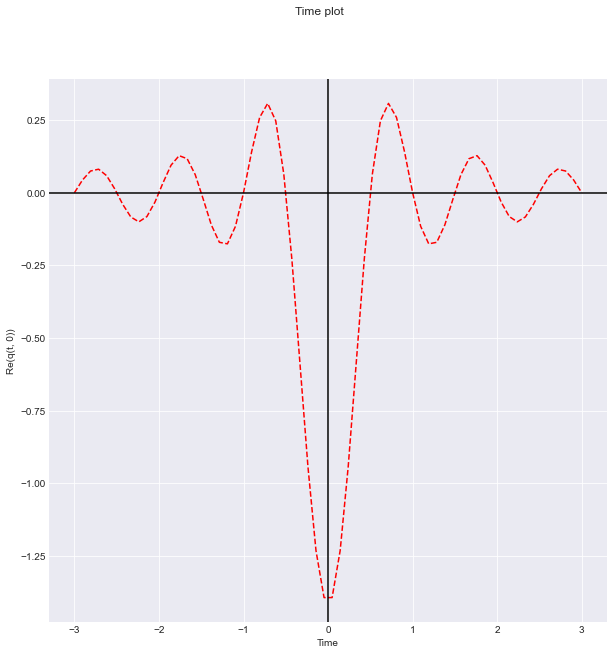

In [14]:
# We will plot the amplitude of q(t, 0) = sqrt(Re(q(t, 0)^2 + Im(q(t, 0))^2)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
fig.suptitle('Time plot')
ax.set_xlabel('Time')
ax.set_ylabel('Re(q(t, 0))')

ax.plot(t, np.squeeze(q0t.real), 'r--')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

plt.show()

## Plot q(f, 0) in frequency

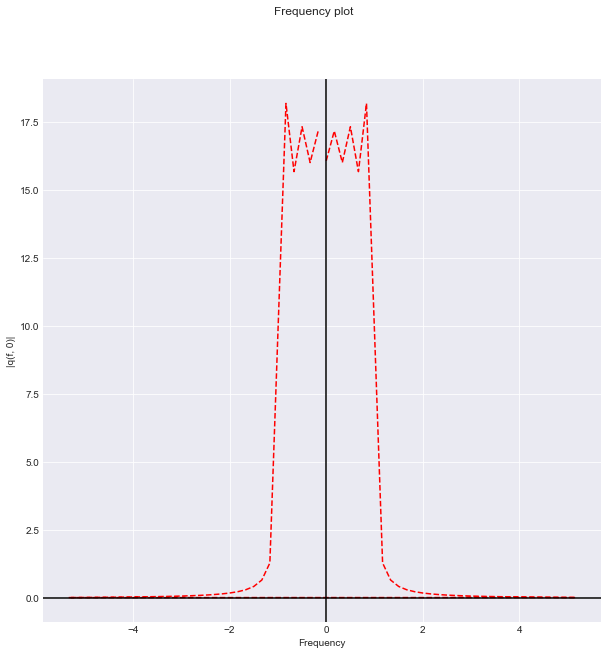

In [15]:
q0f = fft(q0t)

qplot = q0f
xf = fftfreq(N, dt)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
fig.suptitle('Frequency plot')
ax.set_xlabel('Frequency')
ax.set_ylabel('|q(f, 0)|')

ax.plot(xf, np.squeeze(np.absolute(q0f)), 'r--')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

plt.show()

# Channel model

## Channel response Function

In [16]:
# H
def H(f, z):
    w = 2 * np.pi * f
    return np.exp(1j*z*w**2)

# H^-1
def Hinv(f, z):
    return np.reciprocal(H(f, z))

## Channel Function

In [17]:
def channel(t, q0t, z, sigma2, B):
    a = sigma2*B*z  # total noise power in B Hz and distance [0, z]
    f = fftfreq(t.size, 2*t[-1]/t.size)  # get the f vector from t vector

    q0f = fft(q0t)  # input in frequency
    qzf = q0f * H(f, z)  # output in frequency

    # add Guassian noise in frequency, with correct variance
    qzf = qzf + np.random.normal(0, np.sqrt(a), qzf.shape)
    qzt = ifft(qzf) # back to time

    return qzt, qzf

# Receiver

## Equalizer

In [18]:
def equalize(t, qzt, z):
    f = fftfreq(t.size, 2*t[-1]/t.size)  # get the f vector from t vector

    qzf = fft(qzt)  # input in frequency
    qzfe = qzf * Hinv(f, z)  # output in frequency

    qzte = ifft(qzfe) # back to time

    return qzte, qzfe

### Comparison Function

In [19]:
def compare(x, y):
    z = np.absolute(x - y)
    if np.max(z) > 1e-10:
        return False
    return True

### Main

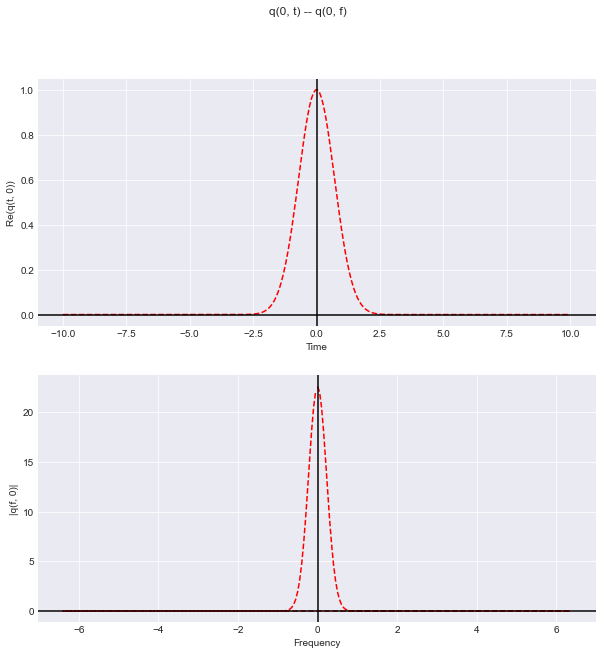

In [20]:
params = Params()

z = 100

# time mesh
T = 20
N = 2**8
# params.setB(2)
dt = T/N
t = np.linspace(-T/2, T/2, num=N, endpoint=True)  # [-T/2 to T/2] with length N

# frequency mesh
F = 1/dt
df = 1/T
# f = np.linspace(F/2, F/2, num=N, endpoint=True)  # [-F/2 to F/2] with length N
f = fftfreq(N, dt)

# t = ifftshift(t)
A = 1
q0t = A*np.exp(-t**2) # Gaussian input, for testing
q0f = fft(q0t)  # input in frequency

# propagation
qzt, qzf = channel(t, q0t, z, 0, 0) # output in t,f. Zero noise.

# plot input output in t; tune T and N accordingly

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(211)
fig.suptitle('q(0, t) -- q(0, f)')
ax.set_xlabel('Time')
ax.set_ylabel('Re(q(t, 0))')

ax.plot(t, np.squeeze(q0t.real), 'r--')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

# plot input output in f; tune T and N accordingly

ax = fig.add_subplot(212)
ax.set_xlabel('Frequency')
ax.set_ylabel('|q(f, 0)|')

ax.plot(f, np.squeeze(np.absolute(q0f)), 'r--')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

plt.show()

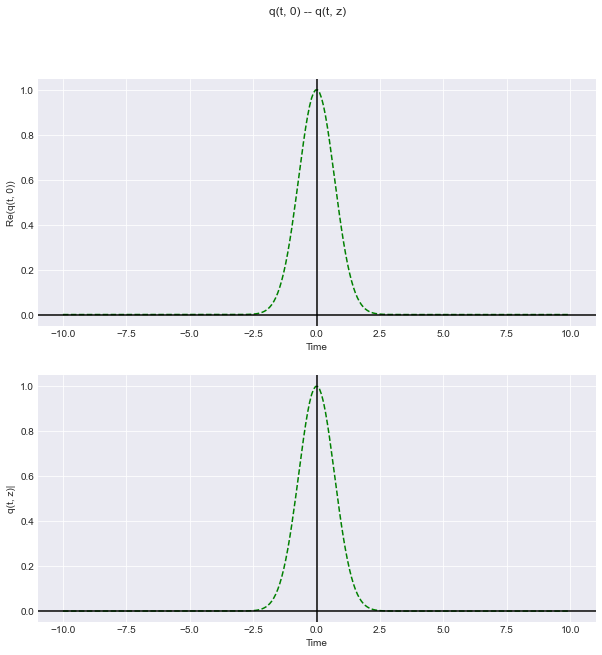

True

In [21]:
# equalization and comparison
qzte, qzfe = equalize(t, qzt, z) # equalized output

# plot input & equalized output in t
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(211)
fig.suptitle('q(t, 0) -- q(t, z)')
ax.set_xlabel('Time')
ax.set_ylabel('Re(q(t, 0))')

ax.plot(t, np.squeeze(q0t.real), 'g--')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

# plot equalized output in t

ax = fig.add_subplot(212)
ax.set_xlabel('Time')
ax.set_ylabel('q(t, z)|')

ax.plot(t, np.squeeze(qzte.real), 'g--')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

plt.show()

compare(q0t, qzte) # compare the equalized signal with the input one

## Demodulation

In [22]:
def demod(t, dt, qzte, B, Ns):
    sl = np.zeros((Ns, 1), dtype=np.complex128)
    l1 = int(-(Ns/2))
    l2 = int((Ns/2) - 1)
    
    lRange = np.linspace(l1, l2, num=Ns, endpoint=True)
    for j, l in enumerate(lRange):
        for i, ti in enumerate(t):
            sl[j] += qzte[0, i] * np.sinc(B*ti-l) * dt
    # print(np.sqrt(B)*LA.norm(np.sinc(B*t)))
    # print(LA.norm(np.sinc(t)))
    shat = np.sqrt(B)*sl
    return shat

## Detection

In [23]:
def detector(shat, M):
    coords, _, _ = getConstellation(M)
    symboles = []
    indexes = []
    for symb in shat:
        diff = np.absolute(symb - coords)**2
        index = np.argmin(diff)
        indexes.append(index)
        symboles.append(coords[index])
    stilde = np.array(symboles)
    return stilde, np.array(indexes)

## Demapping

In [24]:
def symbToBit(indexes, M):
    _, _, binaryArr = getConstellation(M)
    bits = np.ndarray(0, dtype=np.int32)
    for index in indexes:
        bits = np.hstack((bits, binaryArr[index]))
    return bits

### Main

In [38]:
# modulation
nb = 64  # number of bits
M = 16  # order of modulation
ns = int(nb / np.log2(M))  # number of symbols
b = source(nb, p=1/2)  # random bit sequence
B = 1e2  # Bandwidth

T = 50
N = 10**4
# params.setB(2)
dt = T/N
t = np.linspace(-T/2, T/2, num=N, endpoint=True)

s = bitToSymb(b, M)
q0t = mod(t, s, B)

print(q0t.shape)

# propagation & equalization. Set the noise to zero for now
sigma2 = 0
qzt, qzf = channel(t, q0t, z, sigma2, B) # output in t,f
qzte, qzfe = equalize(t, qzt, z) # equalized output

print(qzt.shape)
print(qzte.shape)

# demodulation
shat = demod(t, dt, qzte, B, ns)


# detection
stilde, indexes = detector(shat, M)
bhat = symbToBit(indexes, M)

print(shat.shape)
print(stilde.shape)
print(indexes.shape)
print(bhat.shape)

(1, 10000)
(1, 10000)
(1, 10000)
(16, 1)
(16,)
(16,)
(64,)


In [39]:
z

100

In [40]:
print(np.sum(np.absolute(s - stilde)))

0.0


## Inter-symbol interference



### t0 = 4

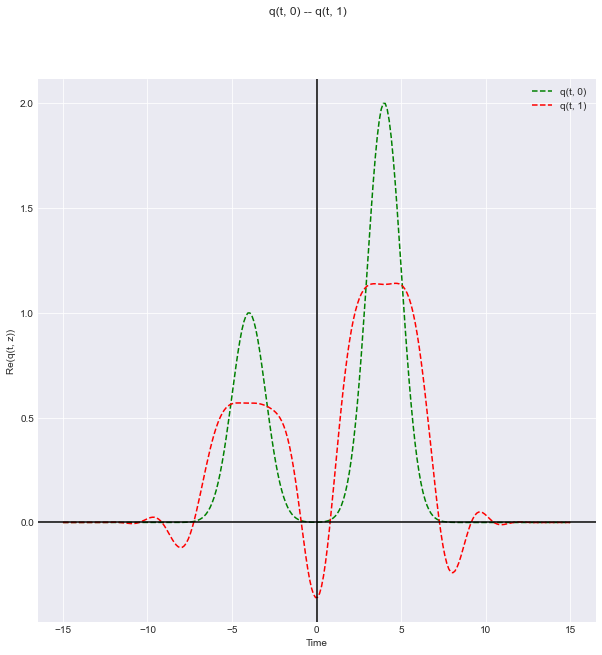

In [59]:
A1 = 1
A2 = 2
D = 1
t0 = 4

T = 30
N = 2**8
# params.setB(2)
dt = T/N
t = np.linspace(-T/2, T/2, num=N, endpoint=True)

z = 1

qt0 = A1*np.exp(-(t+t0)**2/(2*D**2)) + A2*np.exp(-(t-t0)**2/(2*D**2))

qt1, qf1 = channel(t, qt0, z, 0, 0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
fig.suptitle('q(t, 0) -- q(t, 1)')
ax.set_xlabel('Time')
ax.set_ylabel('Re(q(t, z))')

ax.plot(t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
ax.plot(t, np.squeeze(qt1.real), 'r--', label='q(t, 1)')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

ax.legend()

plt.show()

### t0 = 7 | adding some noise

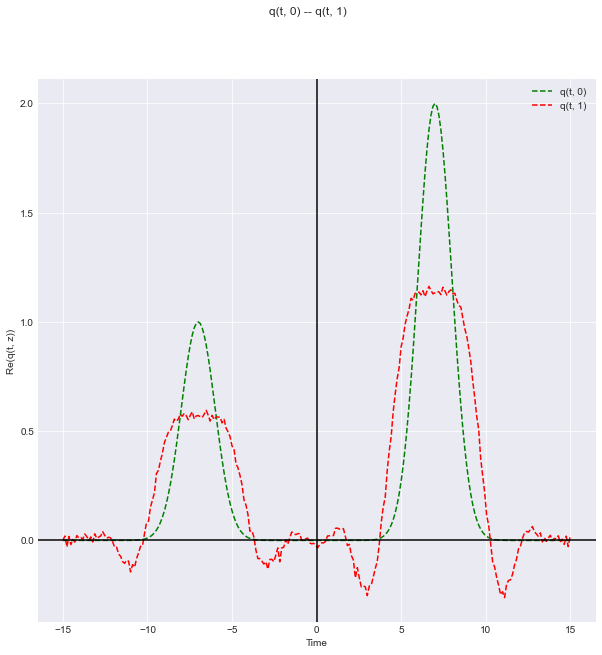

In [60]:
A1 = 1
A2 = 2
D = 1
t0 = 7

T = 30
N = 2**8
# params.setB(2)
dt = T/N
t = np.linspace(-T/2, T/2, num=N, endpoint=True)

z = 1

qt0 = A1*np.exp(-(t+t0)**2/(2*D**2)) + A2*np.exp(-(t-t0)**2/(2*D**2))

qt1, qf1 = channel(t, qt0, z, 0.1, 1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
fig.suptitle('q(t, 0) -- q(t, 1)')
ax.set_xlabel('Time')
ax.set_ylabel('Re(q(t, z))')

ax.plot(t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
ax.plot(t, np.squeeze(qt1.real), 'r--', label='q(t, 1)')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

ax.legend()

plt.show()

### After Equalization

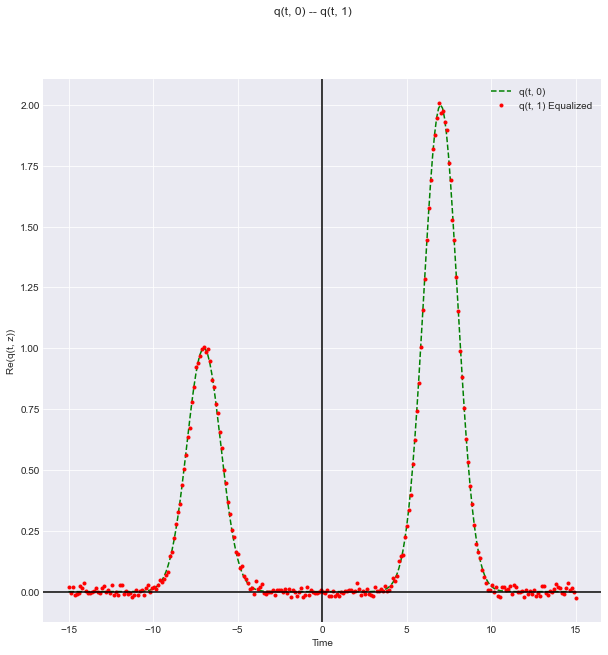

In [61]:
qt1e, qf1e = equalize(t, qt1, z)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
fig.suptitle('q(t, 0) -- q(t, 1)')
ax.set_xlabel('Time')
ax.set_ylabel('Re(q(t, z))')

ax.plot(t, np.squeeze(qt0.real), 'g--', label='q(t, 0)')
ax.plot(t, np.squeeze(qt1e.real), 'r.', label='q(t, 1) Equalized')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

ax.legend()

plt.show()

### Compare Frequency Components

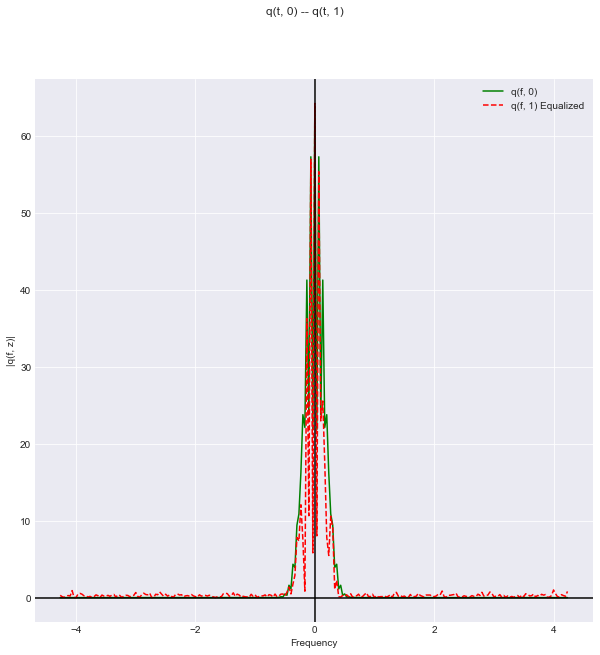

In [62]:
f = fftshift(fftfreq(N, dt))
qf0 = fft(qt0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
fig.suptitle('q(t, 0) -- q(t, 1)')
ax.set_xlabel('Frequency')
ax.set_ylabel('|q(f, z)|')

ax.plot(f, np.absolute(np.squeeze(fftshift(qf0))), 'g-', label='q(f, 0)')
ax.plot(f, np.absolute(np.squeeze(fftshift(qf1.real))), 'r--', label='q(f, 1) Equalized')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

ax.legend()

plt.show()

## Performance Evaluation

### Bit Error Rate / Symbole Error Rate

In [63]:
def ber(b, bhat):
    return np.sum(np.abs(b.T - bhat)) / b.size


def ser(s, shat):
    return np.sum(np.absolute(s - shat)) / s.size

### Calculate BER and PER in a noisy channel

In [64]:
a = 1  # constellation radius
M = 2  # the number of points in the constellation

ser = ser(s, shat)  # symbol error rate
ber = ber(b, bhat)  # bit error rate
# plot the constellation at TX and RX. Change the annotation
# plot(real(cnt), imag(cnt), '*', real(shat), imag(shat), '.');
# plot the BER
# plot(snr, ber)

# Generative Neural Network

## Noise

In [65]:
def noise(n, sigma2, B, dz):
    Pn = sigma2 * B * dz

    Z = fftshift(ifft(np.random.normal(loc=0, scale=np.sqrt(Pn), size=(n, 1))))
    # zIm = np.random.normal(loc=0, scale=np.sqrt(Pn), size=(n, 1))

    # Z = zRe + 1j*zIm

    return Z

## Activation Function

In [66]:
def activation(x, dz):
    return x*np.exp(2j*dz*np.absolute(x)**2)

## Main

In [67]:
def nNetGen(X, z, params, T, nz=500):
    
    n = X.size
    X = X.reshape((-1, 1))
    dz = z/nz

    dt = T/n

    f = fftfreq(n, dt)

    w = 2*np.pi*f

    Hw = np.exp(1j*dz*w**2)
    D = dft(n, scale='sqrtn')
    W = D.conj().T @ np.diag(Hw) @ D

    for k in range(nz):
        # Linear transformation -- multiplication by the weight matrix W
        X = W @ X

        # Activation function
        X = activation(X, dz)

        # AWGN
        # X = X + noise(n, params.sigma2, params.B, dz)

    # AWGN
    # n = noise(n, params.sigma2, params.B, dz)
    n = 0
    Y = np.squeeze(X + n)
    return Y


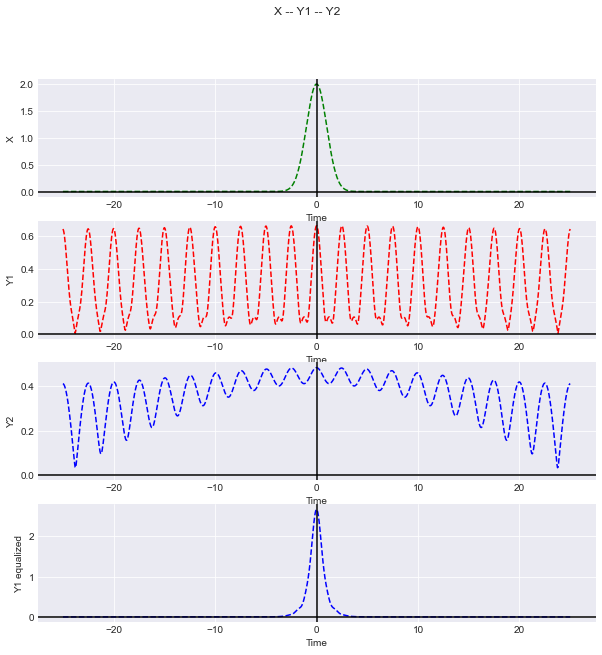

In [68]:
T = 50
N = 10**3
# N = 10
dt = T/N

params = Params()
z = 10

t = np.linspace(-T/2, T/2, num=N, endpoint=True)

A = 2
s = 2
X = A*np.exp(-t**2/s)

F = 1/dt
f = np.linspace(-F/2, F/2, num=n, endpoint=True)

Y1 = nNetGen(X, z, params, T, nz=500)

# Y2, _ = channel(t, X, z, params.sigma2, params.B)
Y2, _ = channel(t, X, z, 0, 0)

Y2e, _ = equalize(t, Y2, z)
Y1e, _ = equalize(t, np.squeeze(Y1), z)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(411)
fig.suptitle('X -- Y1 -- Y2')
ax.set_xlabel('Time')
ax.set_ylabel('X')

# ax.plot(t, X, 'g--')
ax.plot(t, X, 'g--')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

ax = fig.add_subplot(412)
ax.set_xlabel('Time')
ax.set_ylabel('Y1')

ax.plot(t, np.squeeze(np.absolute(Y1)), 'r--')
# ax.plot(t, Y1.real, 'g--')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

ax = fig.add_subplot(413)
ax.set_xlabel('Time')
ax.set_ylabel('Y2')

ax.plot(t, np.absolute(Y2), 'b--')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

ax = fig.add_subplot(414)
ax.set_xlabel('Time')
ax.set_ylabel('Y1 equalized')

ax.plot(t, np.absolute(Y1e), 'b--')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

plt.show()

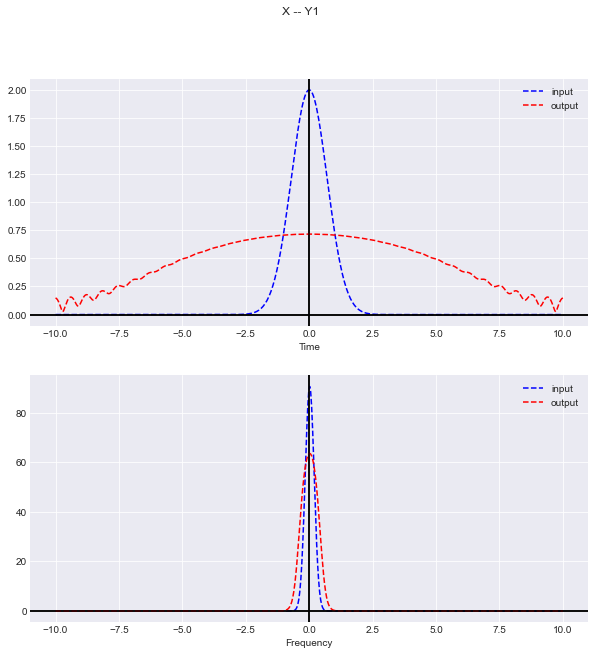

In [69]:
T = 20
N = 2**9
dt = T/N

params = Params()
z = 1

t = np.linspace(-T/2, T/2, num=N, endpoint=True)

A = 2
s = 1
X = A*np.exp(-t**2/s)

f = fftshift(fftfreq(N, dt))

Y1 = nNetGen(X, z, params, T, nz=500)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(211)
fig.suptitle('X -- Y')
ax.set_xlabel('Time')

# ax.plot(t, X, 'g--')
ax.plot(t, X, 'b--', label='input')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

ax.plot(t, np.squeeze(np.absolute(Y1)), 'r--', label='output')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')
ax.legend()

Xf = fftshift(fft(X))
Yf = fftshift(fft(Y1))

ax = fig.add_subplot(212)
fig.suptitle('X -- Y1')
ax.set_xlabel('Frequency')

# ax.plot(t, X, 'g--')
ax.plot(t, np.absolute(Xf), 'b--', label='input')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

ax.plot(t, np.squeeze(np.absolute(Yf)), 'r--', label='output')

ax.axhline(y=0, color='black')
ax.axvline(x=0, color='black')

ax.legend()

plt.show()

# Data Generation

In [71]:
# Parameters
params = Params()
nb = 2**10      # Number of bits
p = 1/2         # P(pi=1) for the bits generation
M = 16          # Size of the QAM Constellation
T = 20          # Time Range
N = 10**3       # Sample Size
dt = T/N        # Step Size
t = np.linspace(-T/2, T/2, num=N, endpoint=True)    # Time Axis
nz = 500        # Number of Layers in the Neural Net
z = 1           # Distance

dataLength = 10**3  # Number of bits distributions
input = np.ndarray((N, dataLength), dtype=np.complex128)
output = np.ndarray((N, dataLength), dtype=np.complex128)

for k in range(dataLength):
    print(f'\rk = {k}', end='')

    # Bernoulli Distributed Bits Generation
    bits = source(nb, p)

    # Bits to Symboles Generation
    symboles = bitToSymb(bits, M)

    # Modulation
    q0t = np.squeeze(mod(t, symboles, params.B))
    input[:, k] = np.squeeze(q0t)

    # Neural Net Generator
    Y = nNetGen(q0t, z, params, T, nz)
    print("[INFO] q0t.shape : ",q0t.shape)  
    print("[INFO] Y.shape : ",Y.shape)

    output[:, k] = Y

print('\nData Generation Completed !')


k = 0[INFO] q0t.shape :  (1000,)
[INFO] Y.shape :  (1000,)
k = 1[INFO] q0t.shape :  (1000,)
[INFO] Y.shape :  (1000,)
k = 2[INFO] q0t.shape :  (1000,)
[INFO] Y.shape :  (1000,)
k = 3[INFO] q0t.shape :  (1000,)
[INFO] Y.shape :  (1000,)
k = 4[INFO] q0t.shape :  (1000,)
[INFO] Y.shape :  (1000,)
k = 5[INFO] q0t.shape :  (1000,)
[INFO] Y.shape :  (1000,)
k = 6[INFO] q0t.shape :  (1000,)
[INFO] Y.shape :  (1000,)
k = 7[INFO] q0t.shape :  (1000,)
[INFO] Y.shape :  (1000,)
k = 8[INFO] q0t.shape :  (1000,)
[INFO] Y.shape :  (1000,)
k = 9[INFO] q0t.shape :  (1000,)
[INFO] Y.shape :  (1000,)
k = 10

KeyboardInterrupt: 

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/data.npz', input=input, output=output)